In [1]:
input_img_path = "../input/gog-dataset/dog.png"
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import inception_v3

In [2]:
from tensorflow.keras.models import load_model,Model
from PIL import Image
import IPython.display as display
import time

In [3]:
def load_image(image_path,max_dim=512):
  img = Image.open(image_path)
  img = img.convert("RGB")
  img.thumbnail([max_dim,max_dim])
  img = np.array(img,dtype=np.uint8)

  img = np.expand_dims(img,0)
  return img



In [4]:
def deprocess_inception_image(img):
  img = 255*(img + 1.0)/2.0
  return np.array(img,dtype=np.uint8)

In [5]:
def array_to_img(array,deprocessing=False):
    if deprocessing:
        array=deprocess_inception_image(array)
    if np.ndim(array)>3:
        assert array.shape[0]==1
        array=array[0]
    return Image.fromarray(array)

In [6]:
def show_image(img):
  image = array_to_img(img)
  display.display(image)


(1, 412, 500, 3)


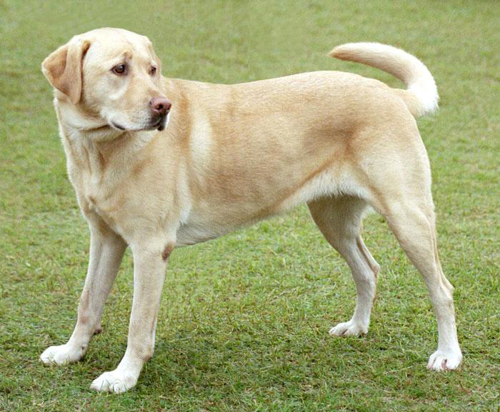

In [7]:
input_image = load_image(input_img_path)
print(input_image.shape)
show_image(input_image)

(1, 412, 500, 3)
(1, 412, 500, 3)


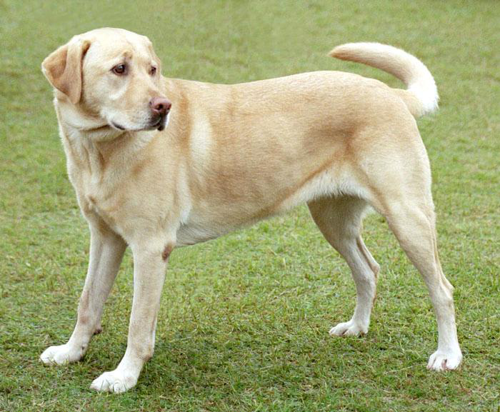

In [8]:
preprocessd_image = inception_v3.preprocess_input(input_image)
print(preprocessd_image.shape)
z = deprocess_inception_image(preprocessd_image)
print(z.shape)
show_image(z)


In [9]:
def deep_deram_model(model,layernames):
  model.trainable = False
  outputs = [model.get_layer(name).output for name in layernames]
  new_model =Model(inputs = model.input,outputs = outputs)
  return new_model



In [10]:
inception = inception_v3.InceptionV3(include_top=False,weights='imagenet')
inception.summary()

87916544/87910968 [==============================] - 1s 0us/step
Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, None, None, 3 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, None, None, 3 0           batch_normalization[0][0]        
______________________

In [11]:
layer_contribuation = ['mixed4','mixed6']
dream_model = deep_deram_model(inception,layer_contribuation)

In [12]:
deep_outputs=dream_model(preprocessd_image)
for layer_name,outputs in zip(layer_contribuation,deep_outputs):
    print(layer_name)
    print(outputs.shape)
    print(outputs.numpy().mean())

mixed4
(1, 24, 29, 768)
0.19235957
mixed6
(1, 24, 29, 768)
0.14369823


In [13]:
model_output= lambda model,inputs:model(inputs)

In [14]:
def get_loss(activations):
  loss =[]
  for activation in activations:
    loss.append(tf.math.reduce_mean(activation))
  return loss  



In [15]:
def get_loss_and_gradient(model,inputs,total_variation_weight = 0):
  with tf.GradientTape() as tape:
    tape.watch(inputs)
    activations = model_output(model,inputs)
    loss = get_loss(activations)
    loss = loss + total_variation_weight * tf.image.total_variation(inputs)
    grads = tape.gradient(loss,inputs)
    grads /= tf.math.reduce_std(grads) + 1e-8 
    return loss,grads

In [16]:
def run_gradient_ascent(model,inputs,epochs=1,steps_per_epoch=1,weight=0.01,total_variation_weight=0):
    img = tf.convert_to_tensor(inputs)
    start=time.time()
    for i in range(epochs):
        print(f"epoch: {i+1}",end=' ')
        for j in range(steps_per_epoch):
            loss,grads=get_loss_and_gradient(model,img,total_variation_weight)
            img = img + grads*weight
            img = tf.clip_by_value(img, -1.0, 1.0)
            print('=',end='')
        print("\n")
    end=time.time()
    print(f"Time elapsed: {end-start:1f}sec")
    return img.numpy()

In [17]:
image_array=run_gradient_ascent(dream_model,preprocessd_image,epochs=5,steps_per_epoch=100,weight=0.01)

epoch: 1 ======

KeyboardInterrupt: 

In [ ]:
show_image(deprocess_inception_image(image_array))
resultant_image=array_to_img(image_array,True)
resultant_image.save("deep_dream_simple.jpg")